In [1]:
import os
os.environ['HF_ENDPOINT'] = 'https://hf-mirror.com'

In [2]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import numpy as np
import matplotlib.pyplot as plt
import json
import string

/home/liubo/miniconda3/envs/sae/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device="cuda:1"
model_name = "gemma-2-2b"
#local_model_path
use_sae= True
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    #attn_implementation="flash_attention_2",
    ).to(device)

`torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 3/3 [00:00<00:00,  4.74it/s]


In [4]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
dataset_path = "../SimpleStories_data/data_250_samples.json"

dataset_list = json.loads(open(dataset_path).read())

total_tokens = 0
check_tokens = []
for sent in dataset_list:
    tokens = tokenizer.encode(dataset_list[sent], add_special_tokens=False)  
    total_tokens += len(tokens)
    check_tokens.append(tokens)

print(f"token num: {total_tokens}")

if tokenizer.pad_token is None:
    if tokenizer.eos_token is not None:
        tokenizer.pad_token = tokenizer.eos_token  
    else:
        tokenizer.add_special_tokens({'pad_token': '[PAD]'})  
        model.resize_token_embeddings(len(tokenizer)) 

token num: 70206


In [5]:
def batch_iter(dataset, batch_size=64):
    batch = []
    for idx in range(len(dataset)):
        batch.append((idx, dataset[str(idx)]))
        if len(batch) >= batch_size:
            yield batch
            batch=[]
    if batch:
        yield batch

def preproc(batch):
    sent_ids = []
    text_data = []
    for idx, text in batch:
        sent_ids.append(int(idx))
        text_data.append(text)
    input_data = tokenizer(
        text_data,
        padding="longest",  
        max_length=256,
        truncation=True,
        return_tensors="pt",
        )
    input_data["sent_ids"] = sent_ids
    return input_data

def is_valid_token(token_str):
    token_lower = token_str.lower()
    tokens = {"<bos>", "<eos>", "<pad>", "<unk>"," "}
    if token_lower in tokens:
        return False
    

    if token_str.isdigit():
        return False
    if all(c in string.punctuation for c in token_str):
        return False
    
    return True

batch_size=32

### Load SAEs of layers from gemma-scope 

In [6]:
layer = 4
if use_sae:
    from sae_lens import SAE
    sae_per_layer = {}
    result = SAE.from_pretrained(
        release="gemma-scope-2b-pt-res-canonical", 
        sae_id=f"layer_{layer}/width_16k/canonical",  
        device='cpu',
    )
    
    sae_obj = result
    sae_per_layer[f"layer_{layer}"] = sae_obj
    
    print(f"Layer {layer}: {type(sae_obj)}")
    sae_per_layer[f"layer_{layer}"].fold_W_dec_norm()


Layer 4: <class 'sae_lens.saes.jumprelu_sae.JumpReLUSAE'>


In [7]:
import torch
import torch.nn.functional as F
from collections import defaultdict
from tqdm import tqdm
import numpy as np
import pandas as pd
import pickle as pkl

# 9b layers:42
# 2b layers 26
vectors_in_diff_layers=[]

all_token_vectors = []
all_token_ids = []
token_nums={}
global_token_count = 0 

if use_sae:
    print(f"recording SAE features of Layer {layer} ...")
    sae = sae_per_layer[f"layer_{layer}"]
    sae.eval() 
else:
    print(f"recording hidden states of Layer {layer} ...")

current_batch_iterator = batch_iter(dataset_list, batch_size)
for batch in tqdm(current_batch_iterator, total=len(dataset_list)//batch_size+1):
    input_data = preproc(batch)
    input_ids = input_data["input_ids"].to(device)

    sent_ids = input_data["sent_ids"] 
    mask = input_data["attention_mask"].to(device)
    
    with torch.no_grad():
        output = model(input_ids=input_ids, attention_mask=mask, output_hidden_states=True)
    
    hidden_states = output["hidden_states"][layer]  # [batch_size, seq_len, hidden_dim]
    batch_size_actual, seq_len, hidden_dim = hidden_states.shape

    for i in range(batch_size_actual):
        current_sent_id = sent_ids[i]
        for j in range(seq_len):
            token_id = input_ids[i, j].item()
            
            if (not is_valid_token(tokenizer.decode(token_id))):
                continue
            if token_id in token_nums:
                token_nums[token_id]+=1
            else:
                token_nums[token_id]=1
            
            if use_sae:
                token_hidden = hidden_states[i, j].to(sae.cfg.device).unsqueeze(0)  # [1, hidden_dim]
                sae_features = sae.encode(token_hidden)  # [1, d_sae]
                token_vec = sae_features.squeeze(0).cpu()  
            else:

                token_vec = hidden_states[i, j].cpu()  # [hidden_dim]
            
            all_token_vectors.append(token_vec)

            token_str=tokenizer.decode(token_id)
            token_sample_id = f"{token_str}-{token_nums[token_id]}"
            all_token_ids.append(token_sample_id)
            
            global_token_count += 1

if use_sae:
    print(f"  Layer {layer}: SAE latents of {len(all_token_vectors)}  tokens")
else:
    print(f"  Layer {layer}: hidden states of {len(all_token_vectors)} tokens")

if len(all_token_vectors) > 0:
    print(f"     feature dimension: {all_token_vectors[0].shape}")




recording SAE features of Layer 4 ...


100%|██████████| 8/8 [00:52<00:00,  6.60s/it]

  Layer 4: SAE latents of 44109  tokens
     feature dimension: torch.Size([16384])


In [8]:
import torch
import torch.nn.functional as F
import pandas as pd

vectors_in_diff_layers.append(all_token_vectors)
all_token_vectors = torch.stack(vectors_in_diff_layers[0])

print(f"shape: {all_token_vectors.shape}")


print(all_token_vectors.shape)

原始向量矩阵 shape: torch.Size([44109, 16384])
torch.Size([44109, 16384])


## 2D projection

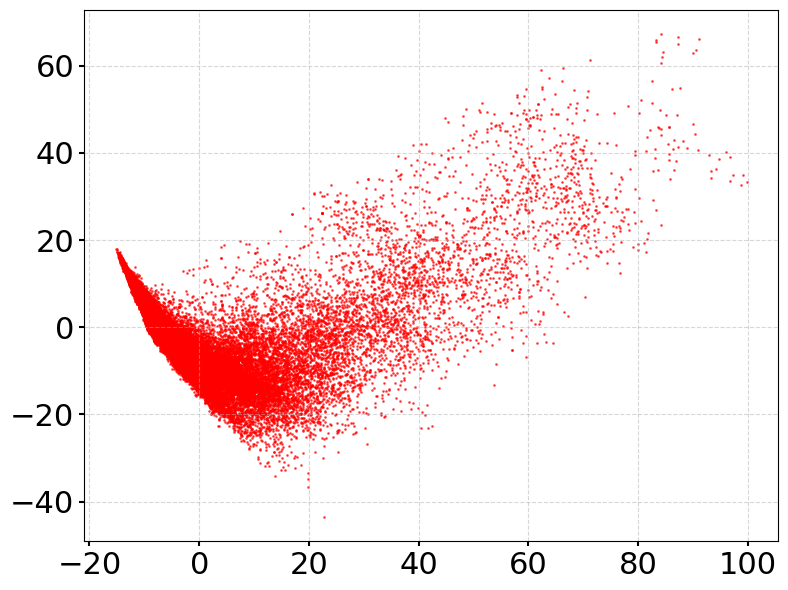

In [13]:
import torch
import matplotlib.pyplot as plt


def svd_projection(W_tensor, device, model_name=""):
    device = device
    W_tensor = W_tensor.to(device).float()
    W_tensor = W_tensor - W_tensor.mean(dim=0, keepdim=True)

    if W_tensor.size(0) > 40000:
        idx = torch.randperm(W_tensor.size(0), device=device)[:40000]
        W_tensor = W_tensor[idx]

    # SVD
    U, S, Vh = torch.linalg.svd(W_tensor, full_matrices=False)
    components = Vh.T[:, :2]     

    # projection
    projection_2d_gpu = W_tensor @ components
    projection_2d_cpu = projection_2d_gpu.cpu().numpy()


    plt.figure(figsize=(8, 6))
    plt.scatter(projection_2d_cpu[:, 0], projection_2d_cpu[:, 1],
                s=1, alpha=0.6, color='red')
    plt.tick_params(axis='both', labelsize=22, width=1.5)
    plt.grid(True, linestyle='--', alpha=0.5)

    plt.tight_layout()
    if model_name:
        plt.savefig(f"../results/SVD_projection/svd_{model_name.split('/')[-1]}.png",bbox_inches='tight', dpi=300)
        #plt.savefig(f"svd_res_{model_name.split('/')[-1]}.pdf",bbox_inches='tight', dpi=300)
    plt.show()
    
svd_projection(all_token_vectors.detach(),device=device,model_name=model_name)